# Voice Leading from the Dynamics of Charged Particles

**Abstract.** In this notebook, we model $n$-part voice leading on the dynamics of $n$ charged particles, with the motion of all particles confined to a single 1-dimensional axis. For the purposes of voice leading, the 1-dimensional axis along which our point-masses move is the (logarithm of) the audio frequency spectrum, so that the position of each particle represents a particular tone. Under this interpretation, the space-time history of the $n$ particles becomes a musical score. We use the `MIDIUtil` library to print the resulting scores as a MIDI files, which can then be imported into most digital audio workstations (DAWs) for further manipulation.

In [76]:
import numpy as np
from scipy.constants import e, epsilon_0, pi

import copy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from midiutil import MIDIFile

## Modeling the dynamics of $n$ charged particles

**Setup.** Let $n$ be a positive integer, and suppose that we have a collection of $n$ positively charged point-masses (or particles) confined to a 1-dimensional axis in 3-dimensional space. Let us label these point-masses with indices $i=0,1,\dots,n-1$. Suppose that we have a 1-dimensional coordinate system on the axis to which the point-masses are confined, so that we can label the positions of the point-masses $x_0, x_1, \dots, x_{n-1}$. Let $q_{0}, q_{1}, \dots, q_{n-1}$ denote the charges of the respective particles, and let $m_{0}, m_{1}, \dots, m_{n-1}$ denote the masses of their masses.

**Obtaining our differential equation.** The force between any two particles in our system is proportional to the inverse square of the distance between the particles. Specifically, the force between the $i^{\text{th}}$ and $j^{\text{th}}$ particles is given by Coulomb's law:
$$
|F_{ij}|\ =\ k\frac{q_i\!\cdot\!q_j}{(x_i-x_j)^2},
$$
where $k$ denotes [the *Coulomb constant*](https://en.wikipedia.org/wiki/Coulomb_constant). In our system consisting of $n$ particles, the total force $F_{i}$ exerted on the $i^{\text{th}}$ particle is then the sum
$$
F_{i}\ = \ \sum_{j\neq i}F_{ij}\ =\ k\cdot q_{i}\cdot\sum_{j\neq i}\text{sgn}(x_i-x_j)\!\cdot\!\frac{q_j}{(x_i-x_j)^2}.
$$

Using Newton's Second Law of Motion $F = m\tfrac{d^2x}{dt^2}$, we obtain a differential equation describing the acceleration of the $i^{\text{th}}$ particle, at a given time $t$, in terms of the positions of all particles in the system at time $t$:
$$
\frac{d^{2}x_i}{dt^2}\ =\ k\frac{q_{i}}{m_i}\sum_{j\neq i}\text{sgn}(x_i-x_j)\!\cdot\!\frac{q_j}{(x_i-x_j)^2}.
$$

**Modeling the dynamics of our system via Python class methods.** We model the dynamics of our system of particles by using [*Euler's method*](https://en.wikipedia.org/wiki/Euler_method) to obtain an approximate, numerical solution to the above differential equation for each index $i=0, 1, \dots, n-1$. Specifically, we define a Python class `ParticleSystem`, representing our system of $n$ particles at a given time $t$, that we equipped with a method `eulerStep` that creates a new instance of our `ParticleSystem` at time $t+\Delta t$, that is, one time step $\Delta t$ into the future. In this way, we obtain a numerical approximation of the complete time evolution of our system by simply iterating the `eulerStep` method.

In an effort to keep our code digestible, we package the parameters for our physical system into three separate classes to serve as arguments for our `ParticleSystem` class. We call these organizing classes `Bounds`, `ParticleDetails`, and `DynamicalVariables`. They organize the parameters of our physical system as follows:

$$
    \left.
    \begin{array}{r}
    \text{lowerbound position}
    \\
    \text{lowerbound charge}
    \\
    \text{upperbound position}
    \\
    \text{upperbound charge}
    \\
    \text{buffer parameter}
    \end{array}
    \right\}
    \texttt{Bounds},
\ \ \ \ \ \ 
    \left.
    \begin{array}{c}
    \text{free particle masses}
    \\
    \text{free particle charges}
    \end{array}
    \right\}
    \texttt{ParticleDetails},
\ \ \ \ \ \ 
    \left.
    \begin{array}{c}
    \text{time}
    \\
    \text{free particle positions}
    \\
    \text{free particle velocities}
    \end{array}
    \right\}
    \texttt{DynamicalVariables}.
$$

**Note on Coloumb's constant in the code below.** The specific behavior of a physical system consisting of charged particles depends on the value of Coloumb's constant. In physical reality, this constant Coloumb's constant is deeply intertwined with phenomenon like the scale, mass, and speed at which particle interactions take place. In order to make the values of these parameters more reasonable from a user perspective, we include the ability to change the value of Coulomb's constant in the code below. We often think of Coulomb's constant as a scalar contolling the force between two charged particles, but in the code below, we implement it wihtin Euler's method, so that it becomes a scalar controlling the acceleration of particles in our physical system. Roughly speaking, you can think of this parameter as controlling something like "how close particle have to get to one another before they repel/attract one another."

In [2]:
class Bounds():
    """Class representing a pair of distinct, charged particles forming the boundary of a physical system.
    """
    def __init__(self,
            bounds = [-5.0, 5.0],
            bound_charges = [1.0, 1.0],
            buffer = 1e-3):
        """Creates an instance of the Bounds class from specified values.
        
        Keyword arguments:
        bounds -- positions of the two charged particles (default [-2.0, 2.0])
        velocities -- charges of the two charged particles (default [1.0, 1.0])
        buffer -- a numerical value to prevent particles from getting too close to the bounds (default 1e-3)
        """
        
        assert type(bounds) == type(bound_charges) == list
        assert len(bounds) == len(bound_charges)== 2
        assert bounds[0] < bounds[1]
        assert buffer > 0.0
        assert buffer < bounds[1]-bounds[0]
        
        # Unpack class arguments as class attributes:
        self.min_bound = bounds[0]
        self.max_bound = bounds[1]
        self.minbound_charge = bound_charges[0]
        self.maxbound_charge = bound_charges[1]
        self.buffer = buffer

In [3]:
class ParticleDetails():
    """Class representing the mass and charge of particles in a physical system.
    """
    def __init__(self,
            masses = [1.0, 1.0, 1.0],
            charges = [1.0, 1.0, 1.0]):
        """Creates an instance of the ParticleDetails class from specified values.
        
        Keyword arguments:
        positions -- masses of the particles in a physical system (default [1.0, 1.0, 1.0])
        velocities -- charges of the particles in a physical system (default [1.0, 1.0, 1.0])
        """
        
        assert type(masses) == type(charges) == list
        assert len(masses) == len(charges)
        for i in range(len(masses)):
            assert type(masses[i]) == type(charges[i]) == float
            assert masses[i] > 0.0

        # Number of particles in our system:
        self.cardinality = len(masses)
        
        # Convert class arguments to class attributes:
        self.masses = masses
        self.charges = charges

In [4]:
class DynamicalVariables():
    """Class representing the dynamical variables time, position, and velocity of a physical system.
    """
    def __init__(self,
            time = 0.0,
            positions = [-1.0, 0.0, 1.0],
            velocities = [0.0, 0.0, 0.0]):
        """Creates an instance of the DynamicalVariables class from specified values.
        
        Keyword arguments:
        time -- time of the physical system (default 0.0)
        positions -- list of positions of the particles in the physical system (default [-1.0, 0.0, 1.0])
        velocities -- list of velocities of the particles in the physical system (default [0.0, 0.0, 0.0])
        """
        
        assert type(time) == float
        assert type(positions) == type(velocities) == list
        assert len(positions) == len(velocities)
        for i in range(len(positions)):
            assert type(positions[i]) == type(velocities[i]) == float
        
        # Number of particles in our system:
        self.cardinality = len(positions)
        
        # Convert all class arguments to class attributes:
        self.time = time
        self.positions = positions
        self.velocities = velocities
        
        # Turn the two extreme positions of the particles into attributes:
        self.max_position = max(positions)
        self.min_position = min(positions)

In [7]:
class ParticleSystem():
    """Class representing a physical system consisting of n charged particles bound between a pair of charged
    particles at a given time.
    
    This class comes with a method that lets us implement Euler's method for approximating the state of the
    system and some other time, given its present state.
    """
    def __init__(self,
            bounds,
            particle_details,
            dynamical_variables):
        """Creates an instance of the ParticleSystem class from the basic physical details describing the system.
        
        Keyword arguments:
        bounds -- instance of the Bounds class
            Specifies the pair of fixed, charged particles that serve as bounds for the physical system.
        particle_details -- instance of the ParticleDetails class
            Specifies the masses and charges of all non-boundary particles in the system.
        dynamical_variables -- instance of the DynamicalVariables class
            Specifies the time t and the positions and velocities of all particles in the system at time t. 
        """
        
        assert isinstance(bounds, Bounds)
        assert isinstance(particle_details, ParticleDetails)
        assert isinstance(dynamical_variables, DynamicalVariables)
        
        assert particle_details.cardinality == dynamical_variables.cardinality
        assert dynamical_variables.max_position < bounds.max_bound
        assert dynamical_variables.min_position > bounds.min_bound
        
#        for i in range(dynamical_variables.cardinality-1):
#            assert bounds.buffer < dynamical_variables.positions[i+1]-dynamical_variables.positions[i]
        
        # Pull attributes from the Bounds class argument:
        self.bounds = bounds
        self.min_bound = self.bounds.min_bound
        self.max_bound = self.bounds.max_bound
        self.minbound_charge = self.bounds.minbound_charge
        self.maxbound_charge = self.bounds.maxbound_charge
        self.buffer = self.bounds.buffer
        
        # Pull attributes from the ParticleDetails class argument:
        self.particle_details = particle_details
        self.cardinality = self.particle_details.cardinality
        self.masses = self.particle_details.masses
        self.charges = self.particle_details.charges
        
        # Pull attributes from the DynamicalVariables class argument:
        self.dynamical_variables = dynamical_variables
        self.time = self.dynamical_variables.time
        self.positions = self.dynamical_variables.positions
        self.velocities = self.dynamical_variables.velocities
        
        # Generate list of all pairs (i,j) of particle indices, for i < j,
        # including indices of boundary particles:       
        temp_indices = [i for i in range(self.cardinality)]
        pairs = []
        for i in range(self.cardinality):
            temp_indices.remove(i)
            for j in temp_indices:
                pairs.append((i,j))
            pairs.append((-1, i))
            pairs.append((i, self.cardinality))
        self.pairs = pairs
        
        # Collect positions and charges of all particles, including boundary particles,
        # into a dictionary:
        charges_dict = {i: [self.positions[i], self.charges[i]] for i in range(self.cardinality)}
        charges_dict.update({-1: [self.min_bound, self.minbound_charge],
                             self.cardinality: [self.max_bound, self.maxbound_charge]})
        self.charges_dict = charges_dict
        
        # Create a dictionary of all forces between pairs of particles in the system,
        # including boundary particles:
        force_dict = {}
        for pair in self.pairs:
            radius = max(self.buffer, abs(self.charges_dict[pair[0]][0]-self.charges_dict[pair[1]][0]))
            radius_squared = radius**2
            force = self.charges_dict[pair[0]][1]*self.charges_dict[pair[1]][1] / radius_squared
            force_dict.update({pair: force})
        self.force_dict = force_dict
        
        # Create a list entailing the total force on each non-boundary particle in the system:
        forces = []
        for i in range(self.cardinality):
            running_force = 0.0
            for key in self.force_dict:
                if i in key:
                    index_pair = list(key)
                    index_pair.remove(i)
                    other_index = index_pair[0]
                    sign = np.sign(charges_dict[i][0]-charges_dict[other_index][0])
                    running_force = running_force + float(sign) * self.force_dict[key]
            forces.append(running_force)
        self.forces = forces
        
        # Creat a list entailing the acceleration felt by each non-boundary particle in the system:
        self.accelerations = [self.forces[i]/self.masses[i] for i in range(self.cardinality)]

    
    def eulerStep(self,
                  time_step = 1e-3,
                  coulomb_constant = e**2/(4*pi*epsilon_0)):
        """Uses Euler's method to create a new instance of the ParticleSystem class,
        one time step from the present time.
        
        Keyword arguments:
        time_step -- the time step value for implementing Euler's method, often denoted 'h' or 'Δt'
        coulomb_constant -- scaling factor for all accelerations appearing in Euler's method
        """
        
        assert type(time_step) == float
        
        new_time = self.time + time_step
        
        # Use self.accelerations attribute to generate new velocites for the particles in our system
        new_velocities = [self.velocities[i] + time_step * coulomb_constant * self.accelerations[i]  for i in range(self.cardinality)]
        
        # Use new velocities to generate new positions for the particles in our system:
        new_positions = [self.positions[i] + time_step * new_velocities[i] for i in range(self.cardinality)]
        
        # The approximate nature of Euler's method can create situations where particles jump the boundary.
        # The for-loop below uses self.buffer as a stopgap to prevent such jumps.
        # Instead of jumping the boundary, particles will ricochet off the boundary.
        # Note: This fix is not optimal, and needs to be fixed in future code.
        for i in range(self.cardinality):
            if new_positions[i] > self.max_bound:
                new_positions[i] = self.max_bound - self.buffer/self.velocities[i]
            elif new_positions[i] < self.min_bound:
                new_positions[i] = self.min_bound + self.buffer/self.velocities[i]
        
        # Create a new instance of the DynamicalVariables class, using our new time, positions, and velocities:
        new_dynamical_variables = DynamicalVariables(new_time,
                                                     new_positions,
                                                     new_velocities)
        
        # Return a new instance of our ParticleSystem class,
        # keeping the bounds, masses, and charges of our physical system the same,
        # but updating the system's dynamical details.
        return ParticleSystem(bounds,
                              particle_details,
                              new_dynamical_variables)


**Generating the spacetime history of the physical system.** Now that we've defined the class `ParticleSystem`, representing both a system of $n$ charged particles bound between a pair of fixed particles *and* the one-step evolution of that system via the method `eulerStep`, we can define functions that take any instance of `ParticleSystem` as "seed" and generate histories of the resulting time evolution of the system. We first define a function `history` that outputs a quadruple:
$$
\texttt{history}(\ \textit{particle_system},\ \textit{duration},\ \textit{time_step},\ \textit{coulomb_constant})\ =\ 
\left\{
    \begin{array}{l}
    \text{list of all times at which the system is updated},
    \\
    \text{list of positions of all particles in the system at update times},
    \\
    \text{list of velocities of all particles in the system at update times},
    \\
    \text{list of accelerations of all particles in the system at update times}.
    \\
    \end{array}
\right.
$$

After we define this `history` function, it becomes a relatively simple matter to define a function `plot_history` that uses `matplotlib` to create a 2-dimensional, "spacetime" diagram depicting the full history of the system.

In [75]:
def history(
        particle_system: ParticleSystem,
        duration: float,
        time_step = 1e-3,
        coulomb_constant = e**2/(4*pi*epsilon_0)) -> tuple:
    """Outputs a quadruple (T, P, V, A) representing the time evolution of the initial particle system.
    Entries of this output quadruple are as follows:
            T = list of all time steps used in approximating the time evolution, of the form t+m*Δt,
                where t is our start time and Δt is our time step,
            P = list of positions of all particles in our system at all time steps in T; this list P
                contains one sub-list of positions for each free particle in our system,
            V = list of velocities of all particles in our system at all time steps in T; this list V
                contains one sub-list of velocities for each free particle in our system,
            A = list of accelerations of all particles in our system at all time steps in T; this list A
                contains one sub-list of accelerations for each free particle in our system;
        
    Keyword arguments:
    particle_system -- initial instance of ParticleSystem,
        to be "evolved" via repeated iterations of the eulerStep method
    duration -- the total time duration over which to evolve the system
    time_step -- size of time step to be used in the eulerStep method internal to the ParticleSystem class
    coulomb_constant -- scalar to use in the eulerStep method internal to the ParticleSystem class
    """
    
    assert isinstance(particle_system, ParticleSystem)
    assert type(duration) == type(time_step) == float
    assert duration > 0.0
    
    # Start the lists that will become the outputs T, P, V, and A:
    time_history = [particle_system.time]
    position_history = [[position] for position in particle_system.positions]
    velocity_history = [[velocity] for velocity in particle_system.velocities]
    acceleration_history = [[coulomb_constant * acceleration] for acceleration in particle_system.accelerations]
    
    # Create a copy of our particle system to evolve repreated time steps:
    evolving_system = copy.deepcopy(particle_system)
    
    # Evolve our system, populating the lists P, V, and A as we go:
    iteration_count = 0
    time_passed = 0.0
    while time_passed < duration:
        # Apply the eulerStep method to obtain the state of our system after one time step:
        evolving_system = evolving_system.eulerStep(time_step, coulomb_constant)
        
        # Append the new time t+Δt to the list T:
        time_history.append(evolving_system.time)
        
        # Append the new positions to the list P:
        for i, position in enumerate(evolving_system.positions):
            position_history[i].append(position)
        
        # Append the new velocities to the list V:
        for i, velocity in enumerate(evolving_system.velocities):
            velocity_history[i].append(velocity)
        
        # Append the new accelerations to the list A:
        for i, acceleration in enumerate(evolving_system.accelerations):
            acceleration_history[i].append(coulomb_constant * acceleration)
        
        # Update counters:
        time_passed += time_step
        iteration_count += 1
    
    # Return the quadruple (T, P, V, A):
    return time_history, position_history, velocity_history, acceleration_history


**Plotting function.** Finally, we define a function `plot_history` that takes the upper and lower boundaries of our system, along with the outputs $T =$`time_history`, $P =$`position_history`, and $V =$`velocity_history` of the previous function `history`, and uses the `matplotlib` method `scatter` to print 2-dimensional images representing the "spacetime" evolution of our system of particles. We provide two examples below.

In [71]:
def plot_history(
        upper_boundary,
        lower_boundary,
        T,
        P,
        V):
    f = plt.figure()
    f.set_figwidth(17)
    f.set_figheight(8)

    upper_bound = [upper_boundary for t in T]
    lower_bound = [lower_boundary for t in T]

    plt.scatter(T, upper_bound, s=2, c='lightgray')
    plt.scatter(T, lower_bound, s=2, c='lightgray')

    velocity_maxima = [max(velocities) for velocities in V]
    velocity_absminima = [abs(min(velocities)) for velocities in V]
    velocity_extrema = [max(velocity_maxima[k], velocity_absminima[k]) for k in range(len(V))]
    normalized_speeds = []
    for k in range(len(V)):
        extremum = velocity_extrema[k]
        if extremum == 0.0:
            pass
        else:
            normalized_history = [abs(velocity/extremum) for velocity in V[k]]
        normalized_speeds.append(normalized_history)

    for k, position_history in enumerate(P):
        total = len(P)

        red_angle = (2*np.pi*k/total) + np.pi
        green_angle = (2*np.pi*k/total) + (2*np.pi/3) + np.pi
        blue_angle =  (2*np.pi*k/total) - (2*np.pi/3) + np.pi

        red = (1.0 + np.sin(red_angle))/2.0
        green = (1.0 + np.sin(green_angle))/2.0
        blue =  (1.0 + np.sin(blue_angle))/2.0

        marker_sizes = [10 * speed for speed in normalized_speeds[k]]
        marker_colors = [(.8 * (1.0-speed * red), .8 * (1.0-speed * green), .8 * (1.0-speed * blue)) for speed in normalized_speeds[k]]
        plt.scatter(T, position_history, s=marker_sizes, c=marker_colors)

    plt.axis('off')
    plt.show()


### Example 1
In this first example, we plot the time evolution of a system consisting of three charged particles (<font color=red>*red*</font>, <font color=blue>*blue*</font> and <font color=green>*green*</font> lines below) bound between a fixed pair of particles (<font color=gray>*gray*</font> lines below). The parameters for the three free particles are as follows:

$$
\text{masses}=
\left\{
    \begin{array}{l}
    m_{0} = 1.0
    \\
    m_{1} = 1.0
    \\
    m_{2} = 1.0
    \end{array}
\right.
\ \ \ \ \ \ 
\text{charges}=
\left\{
    \begin{array}{l}
    q_{0} = 1.0
    \\
    q_{1} = 1.0
    \\
    q_{2} = 1.0
    \end{array}
\right.
\ \ \ \ \ \ 
\text{initial positions}=
\left\{
    \begin{array}{l}
    x_{0} = -2.0
    \\
    x_{1} = 0.0
    \\
    x_{2} = 2.0
    \end{array}
\right.
\ \ \ \ \ \ 
\text{initial velocities}=
\left\{
    \begin{array}{l}
    v_{0} = 3.0
    \\
    v_{1} = 5.0
    \\
    v_{2} = -2.0
    \end{array}
\right.
$$

The charges and positions of our two bounding particles are as follows:

$$
\text{charges of bounding particles}=
\left\{
    \begin{array}{l}
    q_{\text{upper}} = 1.0
    \\
    q_{\text{lower}} = 1.0
    \end{array}
\right.
\ \ \ \ \ \ 
\text{positions of bounding particles}=
\left\{
    \begin{array}{l}
    x_{\text{upper}} = 5.0
    \\
    x_{\text{lower}} = -5.0
    \end{array}
\right.
$$
Our starting time is $t_{\text{start}}=0.0$, and we plot the time evolution of the system over the duration of $5.0$ seconds, implementing Euler's method with a time step of $\Delta t=10^{-3}$, with a Coulomb constant defined as $k=5.0$.

In the resulting plot, time proceeds from left-to-right along the horizintal axis. We can readily see the three free particles ricocheting off one another and ricocheting off the two boundary particles.

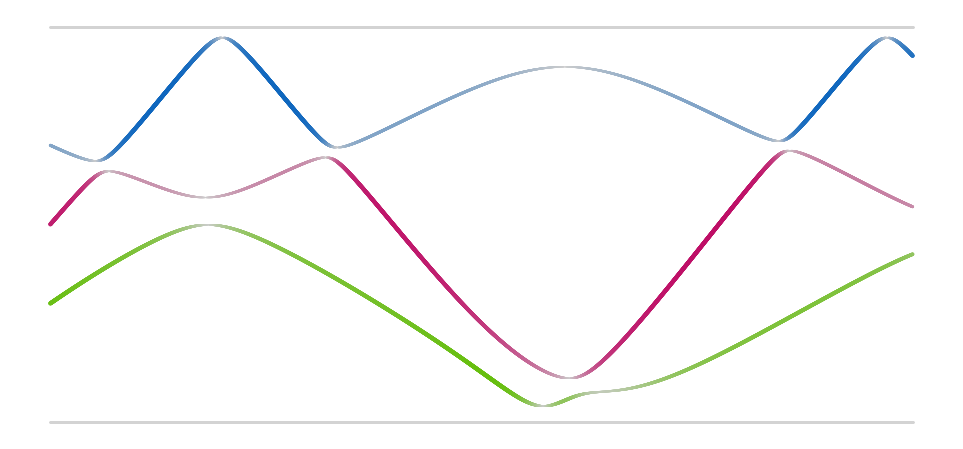

In [72]:
bounds = Bounds()
particle_details = ParticleDetails()
dynamical_variables = DynamicalVariables(0.0, [-2.0, 0.0, 2.0], [3.0, 5.0, -2.0])
particle_system = ParticleSystem(bounds, particle_details, dynamical_variables)

T, P, V, A = history(particle_system,
                     duration = 5.0,
                     time_step = 1e-3,
                     coulomb_constant = 5.0)

plot_history(particle_system.max_bound, particle_system.min_bound, T, P, V)

### Example 2
To give a better example of what the code is capable of, we also provide an example that plots the time evolution of a system consisting of nine free particles. The various parameters defining this system and its time evolution appear in the code below.

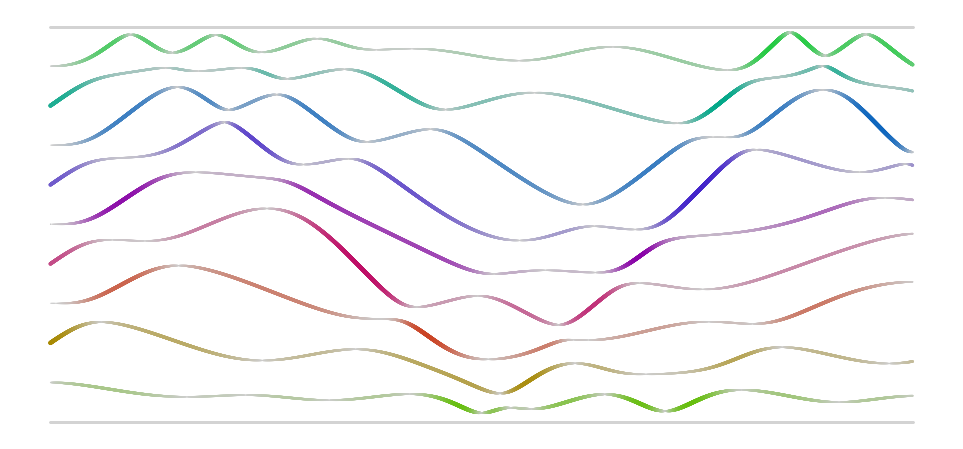

In [73]:
bounds = Bounds([-5., 5.], [.5, .5])
particle_details = ParticleDetails([1., 1., 1., 1., 1., 1., 1., 1., 1.],
                                   [1., 1., 1., 1., 1., 1., 1., 1., 1.])
dynamical_variables = DynamicalVariables(0.0,
                                         [-4., -3., -2., -1., 0., 1., 2., 3., 4.],
                                         [0., 3., 0., 3., 0., 3., 0., 3., 0.])
particle_system = ParticleSystem(bounds, particle_details, dynamical_variables)

T, P, V, A = history(particle_system,
                     duration = 5.0,
                     time_step = 1e-3,
                     coulomb_constant = 5.0)

plot_history(particle_system.max_bound, particle_system.min_bound, T, P, V)

## Printing the time-evolutions to MIDI scores